## Foraging Analyses
This script is inspired by analyses from "Professional Jazz Musicians Explore and Exploit a Space of Sounds" (Williams et al., 2024) and examines euclidean distance and cosine similarity patterns across all transcripts.

**Author:** Helen Schmidt  
**Python version:** 3.11.13

In [19]:
import os
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# define data input location
input_dir = "/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/CANDOR/transcripts/raw"
# define data output location
output_dir = "/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/full-sample"

In [3]:
# load data
df = pd.read_pickle(output_dir + "/full_sample_tile_3_0.pkl")
df.head()

,transcript_id,window_size,gap_size,A_start_turn,A_end_turn,A_utterances,A_embeddings,B_start_turn,B_end_turn,B_utterances,B_embeddings,cosine_similarity,euclidean_distance
0,0020a0c5-1658-4747-99c1-2839e736b481,3,0,1,3,"No, I'm good. How are you? No. Hi, how are you...","[[0.012172122, -0.011064016, 0.06654317, 0.000...",4,6,"Hm My name is played to me Hi, my name's Amand...","[[-0.03531422, -0.04561006, 0.02838244, -0.076...",0.315577,1.169977
1,0020a0c5-1658-4747-99c1-2839e736b481,3,0,2,4,"No. Hi, how are you? Good thanks. Hm My name i...","[[-0.0106563475, -0.06792329, 0.064656146, -0....",5,7,"Hi, my name's Amanda. and the next time you Am...","[[-0.0010068159, -0.09045196, -0.0003150229, -...",0.387075,1.107181
2,0020a0c5-1658-4747-99c1-2839e736b481,3,0,3,5,"Good thanks. Hm My name is played to me Hi, my...","[[-0.038483433, -0.0698858, 0.0062682955, -0.0...",6,8,and the next time you Amanda. All right. Does ...,"[[0.044995096, -0.058201604, -0.028326219, -0....",0.442343,1.056084
3,0020a0c5-1658-4747-99c1-2839e736b481,3,0,4,6,"Hm My name is played to me Hi, my name's Amand...","[[-0.03531422, -0.04561006, 0.02838244, -0.076...",7,9,"All right. Does that time start? Yeah, three o...","[[0.043147173, -0.042117808, -0.027217342, -0....",0.176185,1.283600
4,0020a0c5-1658-4747-99c1-2839e736b481,3,0,5,7,"Hi, my name's Amanda. and the next time you Am...","[[-0.0010068159, -0.09045196, -0.0003150229, -...",8,10,"right. At three. Right, What's that? Don't go ...","[[0.043233756, -0.056193333, -0.049202096, -0....",0.408750,1.087428


### Step Size & Turn Angle

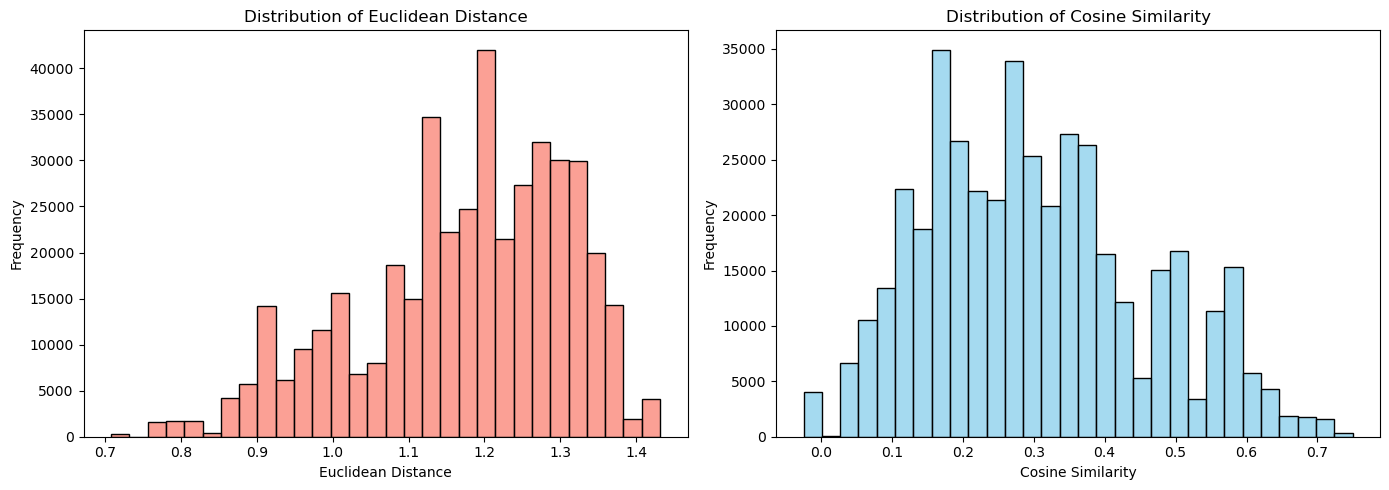

In [4]:
# plot distributions of cosine similarity and euclidean distances
# create figure / axes
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# plot A - step length (euclidean distance)
sns.histplot(df['euclidean_distance'], bins=30, kde=False, ax=axes[0], color='salmon')
axes[0].set_title('Distribution of Euclidean Distance')
axes[0].set_xlabel('Euclidean Distance')
axes[0].set_ylabel('Frequency')

# plot B - turn angles (cosine similarity)
sns.histplot(df['cosine_similarity'], bins=30, kde=False, ax=axes[1], color='skyblue')
axes[1].set_title('Distribution of Cosine Similarity')
axes[1].set_xlabel('Cosine Similarity')
axes[1].set_ylabel('Frequency')

# plot
plt.tight_layout()
plt.show()

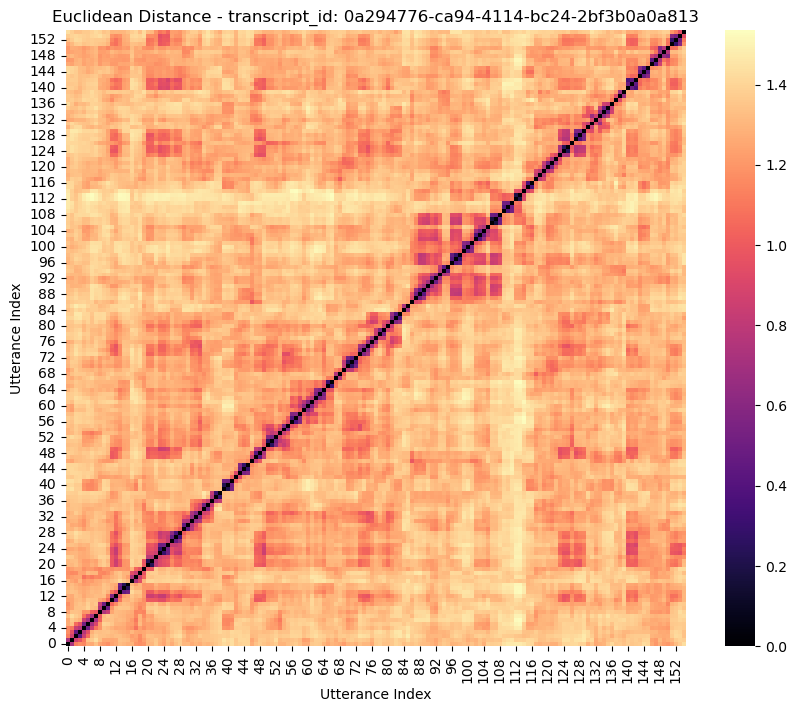

In [5]:
transcript_id = '0a294776-ca94-4114-bc24-2bf3b0a0a813'
subset = df[df['transcript_id'] == transcript_id].reset_index(drop=True)

embedding_matrix = np.vstack(subset['A_embeddings'].values)

distance_matrix = cdist(embedding_matrix, embedding_matrix, metric='euclidean')

plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix, annot=False, cmap='magma')
plt.title(f'Euclidean Distance - transcript_id: {transcript_id}')
plt.gca().invert_yaxis()
plt.xlabel('Utterance Index')
plt.ylabel('Utterance Index')
plt.show()

In [15]:
# test subset
test_df = df.head(1000).copy()

# create a folder in the full sample data output to save heatmaps
heatmap_dir = os.path.join(output_dir, "euclidean-distance-heatmaps")
os.makedirs(heatmap_dir, exist_ok=True)

# loop through each unique transcript_id
for transcript_id in df['transcript_id'].unique():
    subset = df[df['transcript_id'] == transcript_id].reset_index(drop=True)
    # add in skip if not enough data exists to compute distances
    if subset.empty or subset.shape[0] < 2:
        continue
    try:
        # stack embeddings into a matrix
        embedding_matrix = np.vstack(subset['A_embeddings'].values)
        # compute pairwise euclidean distance
        distance_matrix = cdist(embedding_matrix, embedding_matrix, metric = "euclidean")
        # plot heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(distance_matrix, annot=False, cmap='magma')
        plt.title(f'Euclidean Distance - transcript_id: {transcript_id}')
        plt.gca().invert_yaxis()
        plt.xlabel('Utterance Index')
        plt.ylabel('Utterance Index')
        # save each plot
        save_id = transcript_id.replace('/', '_')  # edit ID in case there are problematic characters
        plot_path = os.path.join(heatmap_dir, f"{save_id}.png")
        plt.savefig(plot_path, bbox_inches='tight')
        plt.close()

    except Exception as e:
        print(f"Error creating heatmap for {transcript_id}: {e}")

In [17]:
# test subset
test_df = df.head(1000).copy()

# create a folder in the full sample data output to save heatmaps
heatmap_dir = os.path.join(output_dir, "cosine-similarity-heatmaps")
os.makedirs(heatmap_dir, exist_ok=True)

# loop through each unique transcript_id
for transcript_id in df['transcript_id'].unique():
    subset = df[df['transcript_id'] == transcript_id].reset_index(drop=True)
    # add in skip if not enough data exists to compute distances
    if subset.empty or subset.shape[0] < 2:
        continue
    try:
        # stack embeddings into a matrix
        embedding_matrix = np.vstack(subset['A_embeddings'].values)
        # compute pairwise cosine similarity
        distance_matrix = cdist(embedding_matrix, embedding_matrix, metric = "cosine")
        # plot heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(distance_matrix, annot=False, cmap='magma')
        plt.title(f'Cosine Similarity - transcript_id: {transcript_id}')
        plt.gca().invert_yaxis()
        plt.xlabel('Utterance Index')
        plt.ylabel('Utterance Index')
        # save each plot
        save_id = transcript_id.replace('/', '_')  # edit ID in case there are problematic characters
        plot_path = os.path.join(heatmap_dir, f"{save_id}.png")
        plt.savefig(plot_path, bbox_inches='tight')
        plt.close()

    except Exception as e:
        print(f"Error creating heatmap for {transcript_id}: {e}")

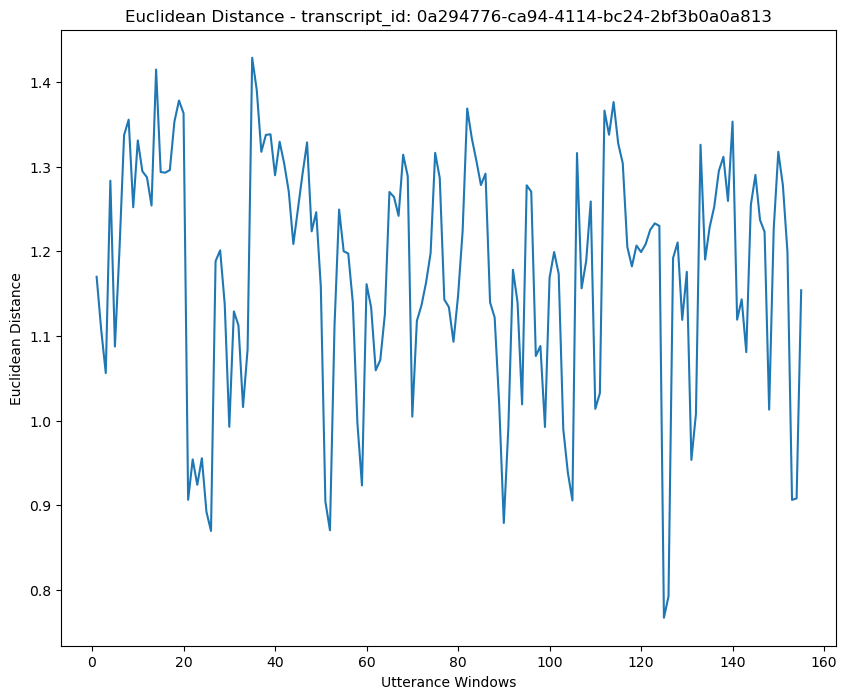

In [7]:
# plot a conversation's peaks of euclidean distances and cosine similarities
transcript_id = '0a294776-ca94-4114-bc24-2bf3b0a0a813'
#transcript_id = '339012e4-ada1-4c88-839d-08a6842b5903'
subset = df[df['transcript_id'] == transcript_id].reset_index(drop=True)

plt.figure(figsize=(10, 8))
sns.lineplot(data=subset, x='A_start_turn', y='euclidean_distance')
plt.title(f'Euclidean Distance - transcript_id: {transcript_id}')
plt.xlabel('Utterance Windows')
plt.ylabel('Euclidean Distance')
plt.show()

## Cosine of the turn angle

In [23]:
def compute_turn_angles_adjacent_windows(df):
    results = []

    # group by transcript
    for transcript_id, group in df.groupby('transcript_id'):
        if len(group) < 2:
            continue  # need at least 2 windows to compute a turn
        
        # stack the embeddings to ensure 2D arrays (number of points, embedding dimension)
        A = np.vstack([emb.squeeze() for emb in group['A_embeddings'].values[:-1]])
        B = np.vstack([emb.squeeze() for emb in group['B_embeddings'].values[:-1]])
        C = np.vstack([emb.squeeze() for emb in group['B_embeddings'].values[1:]])
        
        # compute vectors from the middle point (B)
        BA = A - B
        BC = C - B
        
        # calculate cosine similarity
        cos_theta = np.array([cosine_similarity(BA[i].reshape(1,-1), BC[i].reshape(1,-1))[0,0]
                              for i in range(len(BA))])
        
        # save results for this transcript
        res_df = pd.DataFrame({
            'transcript_id': transcript_id,
            'turn_index': np.arange(len(cos_theta)),  # starts at 0
            'cosine_turn': cos_theta
        })
        results.append(res_df)
    
    # combine all transcripts
    return pd.concat(results, ignore_index=True)


In [24]:
angles_df = compute_turn_angles_adjacent_windows(df)
print(angles_df.head())

                          transcript_id  turn_index  cosine_turn
0  0020a0c5-1658-4747-99c1-2839e736b481           0     0.358939
1  0020a0c5-1658-4747-99c1-2839e736b481           1    -0.267124
2  0020a0c5-1658-4747-99c1-2839e736b481           2    -0.091360
3  0020a0c5-1658-4747-99c1-2839e736b481           3     0.196351
4  0020a0c5-1658-4747-99c1-2839e736b481           4     0.332365


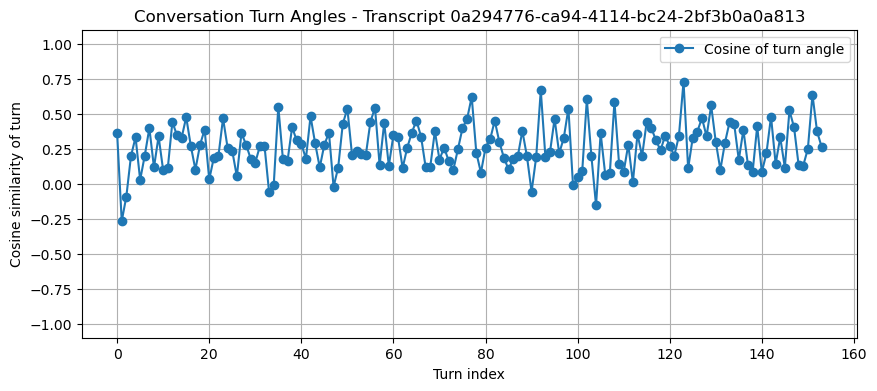

In [25]:
example_transcript = "0a294776-ca94-4114-bc24-2bf3b0a0a813"
example_df = angles_df[angles_df['transcript_id'] == example_transcript]

# Plot cosine of turn angles
plt.figure(figsize=(10, 4))
plt.plot(example_df['turn_index'], example_df['cosine_turn'], marker='o', label='Cosine of turn angle')
plt.title(f"Conversation Turn Angles - Transcript {example_transcript}")
plt.xlabel("Turn index")
plt.ylabel("Cosine similarity of turn")
plt.ylim(-1.1, 1.1)
plt.grid(True)
plt.legend()
plt.show()


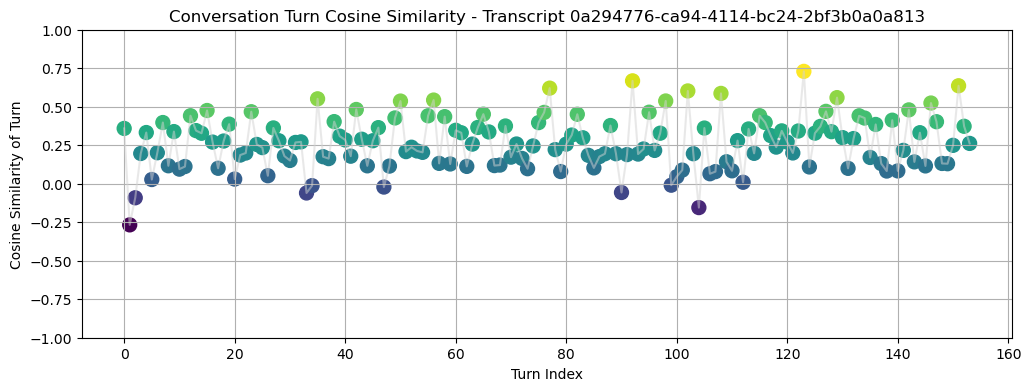

In [27]:
import matplotlib.cm as cm

example_transcript = "0a294776-ca94-4114-bc24-2bf3b0a0a813"
example_df = angles_df[angles_df['transcript_id'] == example_transcript]

norm = (example_df['cosine_turn'] - example_df['cosine_turn'].min()) / \
       (example_df['cosine_turn'].max() - example_df['cosine_turn'].min())
colors = cm.viridis(norm)

plt.figure(figsize=(12, 4))
plt.scatter(example_df['turn_index'], example_df['cosine_turn'], c=colors, s=100)
plt.plot(example_df['turn_index'], example_df['cosine_turn'], color='lightgray', alpha=0.5)
plt.xlabel("Turn Index")
plt.ylabel("Cosine Similarity of Turn")
plt.title(f"Conversation Turn Cosine Similarity - Transcript {example_transcript}")
plt.ylim(-1, 1)
plt.grid(True)
plt.show()

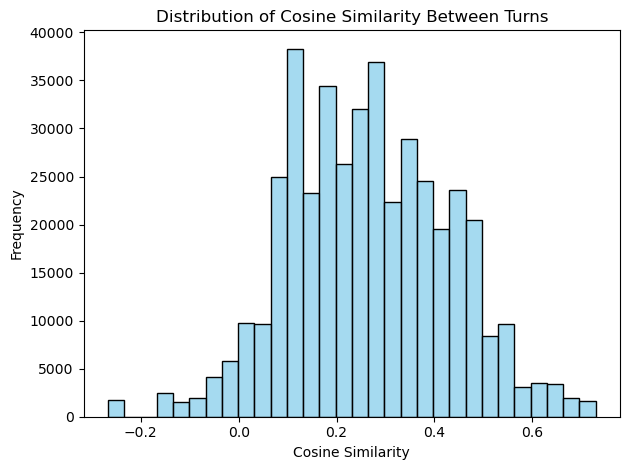

In [33]:
# distribution of cosine of turn similarity
sns.histplot(angles_df['cosine_turn'], bins=30, kde=False, color='skyblue')
plt.title('Distribution of Cosine Similarity Between Turns')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

# plot
plt.tight_layout()
plt.show()

In [ ]:
# what's the cosine similarity of turn angles in the bottom 10% of the data?
threshold = np.percentile(angles_df['cosine_turn'], 10)
print("Threshold for large jumps (10th percentile):", threshold)
# cosine similarities lower than 0.079 are considered "big jumps"

Threshold for large jumps (10th percentile): 0.0790984183549881


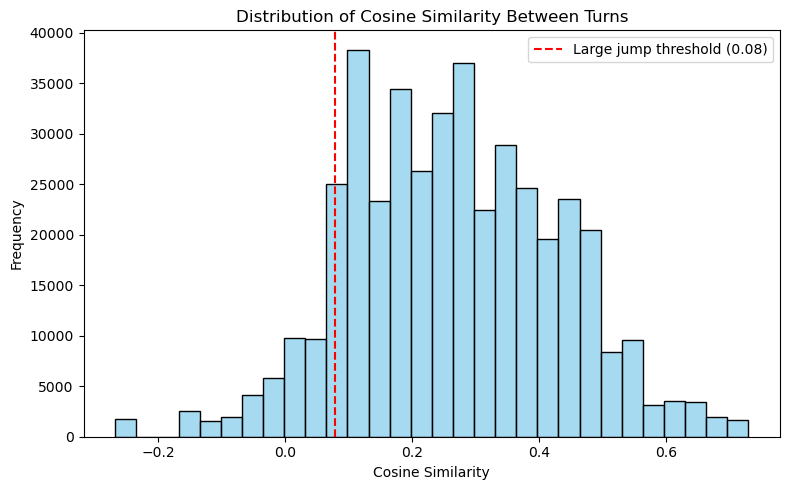

In [35]:
plt.figure(figsize=(8, 5))
sns.histplot(angles_df['cosine_turn'], bins=30, kde=False, color='skyblue')
plt.axvline(threshold, color='red', linestyle='--', label=f'Large jump threshold ({threshold:.2f})')
plt.title('Distribution of Cosine Similarity Between Turns')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

In [43]:
example_transcript = angles_df['transcript_id'].iloc[0]
example_df = angles_df[angles_df['transcript_id'] == example_transcript].copy()

# Threshold for large jumps
threshold = np.percentile(angles_df['cosine_turn'], 10)
example_df['large_jump'] = example_df['cosine_turn'] < threshold

# Correctly assign turn_index aligned to the example transcript
example_df['turn_index'] = df.loc[df['transcript_id'] == example_transcript, 'A_start_turn'].iloc[1:1+len(example_df)].values

# Merge utterances
example_df = example_df.merge(
    df[['transcript_id', 'A_start_turn', 'A_utterances']],
    on=['transcript_id', 'A_start_turn'],
    how='left'
)

# Plot cosine similarity
plt.figure(figsize=(14, 5))
plt.plot(example_df['turn_index'], example_df['cosine_turn'], marker='o', color='skyblue', label='Cosine Similarity')

# Highlight large jumps
plt.scatter(example_df.loc[example_df['large_jump'], 'turn_index'],
            example_df.loc[example_df['large_jump'], 'cosine_turn'],
            color='red', s=100, label='Large Jump')

plt.axhline(threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.2f})')

# Annotate utterances for large jumps
for idx, row in example_df[example_df['large_jump']].iterrows():
    plt.text(row['turn_index'], -0.15, row['A_utterances'], rotation=45, ha='right', va='top', fontsize=8, wrap=True)

plt.xlabel("Turn Index")
plt.ylabel("Cosine Similarity")
plt.title(f"Conversation Turn Cosine Similarity with Large Jumps & Utterances - Transcript {example_transcript}")
plt.ylim(-0.3, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


KeyError: 'A_start_turn'

## Data checks

*Check number of annotated transcripts, see if there are any IDs that don't have an annotator*

### Foote Novelty

*To Do:*
1) look at peaks in distances across conversations to figure out foote novelty thresholds
2) take cosine of the angle between vectors (e.g., the distance between cosine of window 1 and window 2 and cosine of window 2 and window 3)


Do we just combine utterances from 1/2 and 2/3 to find distance between sets?
find periods where the similarity between windows is greater than similarity within